# Explainability, Interpretability & Model Inspection

One way to probe the models we build is to test them against the established knowledge of domain experts. 

In this section, we’ll explore how to build intuitions about our machine learning model and avoid pitfalls like spurious correlations. These methods for model interpretability increase our trust into models, but they can also serve as an additional level of reproducibility in our research and a valuable research artefact that can be discussed in a publication.

We will also go into some considerations why the feature importance of tree-based methods can serve as a start but often shouldn’t be used as the sole source of truth regarding feature interpretation of our applied research.

Let's answer some common questions about explainable AI, and ML interpretability first. For one, there's a question of the difference between explainability and interpretability. You can make the distinction that some models are inherently more interpretable, these methods can include linear models, [RuleFit](https://christophm.github.io/interpretable-ml-book/rulefit.html) and decision trees. Explainability is often used as a post-hoc method to explain a models behaviour afterwards. Realistically, interpretability and explainability or often used interchangeably.

Generally, we can distinguish between different types of explainability:

- Local: Explaining why a prediction was made for a specific data sample.
- Global: How a model generally behaves.

Local methods are great for transparency, such as, explaining why a person's loan was denied. They're not great for general conclusions about model performance, however, since a single sample cannot be representative of a dataset. Local explainability is often used in publications as a story-telling device to build intuition, but shouldn't stand alone.

Global methods are more appropriate for model inspection. They can explain the general trends in a model, such as the importance of features in the data. These can be used to evaluate a model against the intuition of domain experts and established knowledge. These global methods can also be used to evaluate the model against a test data set.

This section will introduce tools like `shap` and partial dependence plots, discuss feature importance, and manual inspection of neural network models.

First we'll split the data from [the Data notebook](/notebooks/0-basic-data-prep-and-model.html) and load the model from [the Sharing notebook](https://ml.recipes/notebooks/3-model-sharing.html).

In [1]:
from pathlib import Path

DATA_FOLDER = Path("..", "..") / "data"
DATA_FILEPATH = DATA_FOLDER / "penguins_clean.csv"

In [3]:
import pandas as pd
penguins = pd.read_csv(DATA_FILEPATH)
penguins.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Species
0,39.1,18.7,181.0,MALE,Adelie Penguin (Pygoscelis adeliae)
1,39.5,17.4,186.0,FEMALE,Adelie Penguin (Pygoscelis adeliae)
2,40.3,18.0,195.0,FEMALE,Adelie Penguin (Pygoscelis adeliae)
3,36.7,19.3,193.0,FEMALE,Adelie Penguin (Pygoscelis adeliae)
4,39.3,20.6,190.0,MALE,Adelie Penguin (Pygoscelis adeliae)


In [4]:
from sklearn.model_selection import train_test_split
num_features = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)"]
cat_features = ["Sex"]
features = num_features + cat_features
target = ["Species"]

X_train, X_test, y_train, y_test = train_test_split(penguins[features], penguins[target[0]], stratify=penguins[target[0]], train_size=.7, random_state=42)

In [6]:
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from joblib import dump, load

MODEL_FOLDER = Path("..", "..") / "model"
MODEL_EXPORT_FILE = MODEL_FOLDER / "svc.joblib"

model = load(MODEL_EXPORT_FILE)
model.score(X_test, y_test)

1.0

With the model loaded correctly, we can start diving into explainable AI, interpretability and model inspection!

## Partial Dependence for Machine Learning Interpretability

The scikit-learn library provides powerful tools for understanding the relationship between features and the target variable in machine learning models, including the `PartialDependenceDisplay` and `partial_dependence` functions. These tools enable us as researchers to visualize and quantify the impact of individual features on model predictions, helping to uncover complex patterns and relationships within the data. 

The partial dependence plots attempt to show an "average response" of a model to a certain feature changing.

The `PartialDependenceDisplay` function offers an intuitive way to visualize the partial dependence of the target variable on one or two features, allowing researchers to assess how the model's predictions change as the values of these features vary while marginalizing over the values of all other features. 

Similarly, the `partial_dependence` function computes the partial dependence of the target variable on one or more features, providing numerical values that quantify the magnitude and direction of the relationship between each feature and the target. 

In [8]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from matplotlib import pyplot as plt


pd_results = partial_dependence(model, X_train.sample(5), num_features)
print(pd_results.keys())
print(f"Example Values: {pd_results['values'][0]}, Average: {pd_results['average'][0][0].mean(axis=0)}")

dict_keys(['average', 'values'])
Example Values: [36.7 40.7 42.  45.2 46.8], Average: [2.22617785 2.22582212 2.22447596 2.21217622 1.92981706]


Luckily, we already have the plotting functionality available from scikit-learn directly and re-use the model we loaded earlier!

We'll create a partial dependence plot for each penguin class!

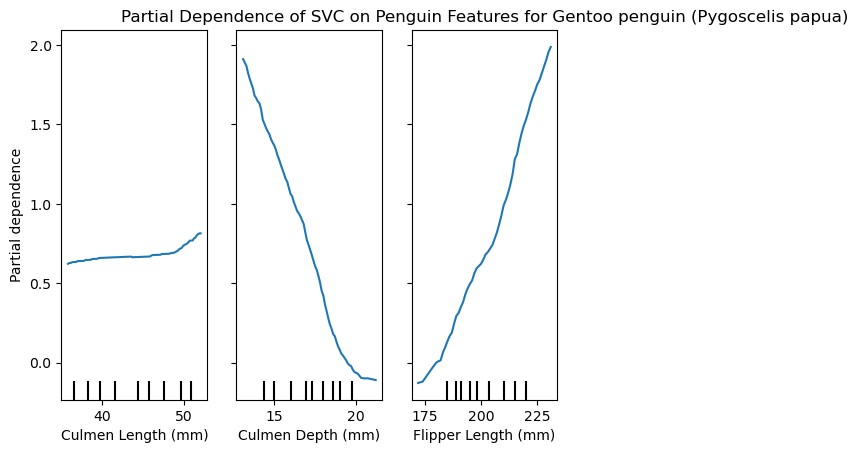

In [9]:
PartialDependenceDisplay.from_estimator(model, X_train, [0,1,2], target=list(y_train.unique())[0])
plt.title(f"Partial Dependence of SVC on Penguin Features for {y_train.unique()[0]}")
plt.show()

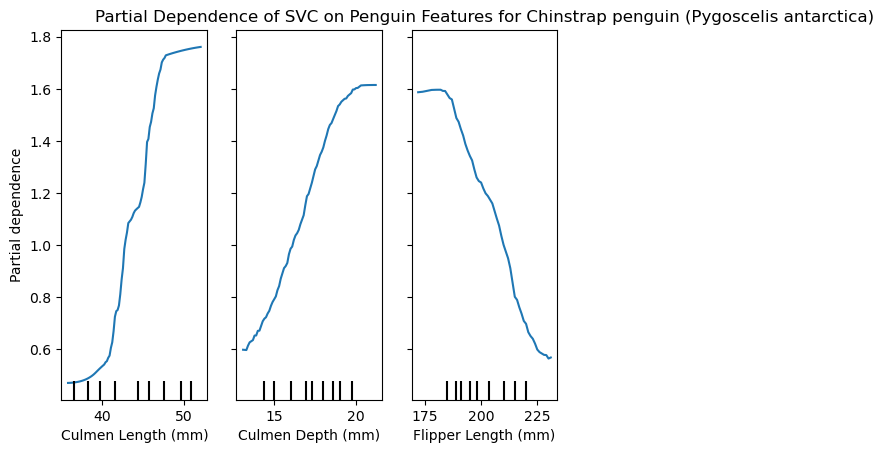

In [10]:
PartialDependenceDisplay.from_estimator(model, X_train, [0,1,2], target=list(y_train.unique())[1])
plt.title(f"Partial Dependence of SVC on Penguin Features for {y_train.unique()[1]}")
plt.show()

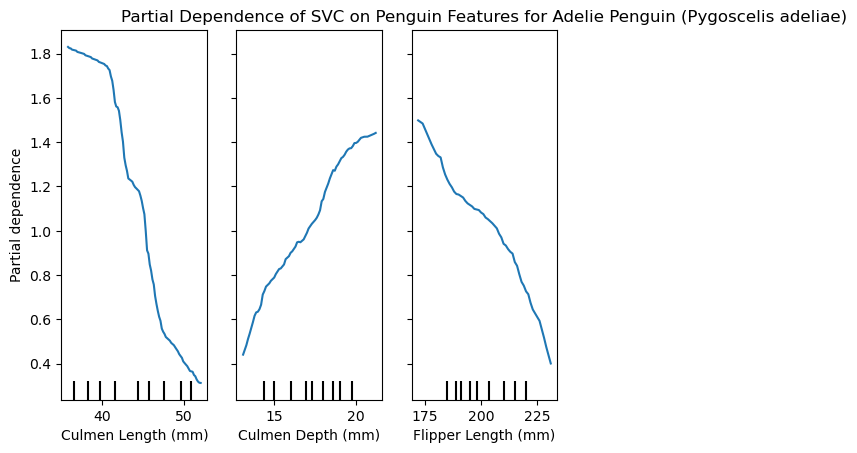

In [11]:
PartialDependenceDisplay.from_estimator(model, X_train, [0,1,2], target=list(y_train.unique())[2])
plt.title(f"Partial Dependence of SVC on Penguin Features for {y_train.unique()[2]}")
plt.show()

These plots can be very insightful, if you know how to interpret them correctly.

We have the 3 features and how varying these changes the impact in predicting a specific class.

Interestingly, we can see that the Culmen length for Adelie is smaller, because larger values reduce the partial dependence, Chinstrap penguins however seem to have a larger Culmen length, and Gentoo is almost unaffected by this feature!

Similarly only Gentoo seems to have larger Flippers, whereas smaller flippers have a lower partial dependence for large values.

I'm not a penguin expert, I just find them adorable, and I'm able to glean this interpretable information from the plots. I think is a great tool! 🐧

### Feature importances with Tree importance vs Permutation importance

Understanding feature importance is crucial in machine learning, as it helps us identify which features have the most significant impact on model predictions. 

Two standard methods for assessing feature importance are Tree Importance and Permutation Importance.
Tree Importance, usually associated with tree-based models like random forests, calculates feature importances based on how frequently a feature is used to split nodes in the trees. It's a counting exercise.

Features frequently selected for splitting are considered more important because they contribute more to the model's predictive performance. One benefit of Tree Importance is its computational efficiency, as feature importance can be readily obtained by training. However, Tree Importance may overestimate the importance of correlated features, features with high cardinality and randomness, and features that struggle with feature interactions.

On the other hand, Permutation Importance assesses feature importance by measuring the decrease in model performance when the values of a feature are randomly shuffled. Features that, when shuffled, lead to a significant decrease in model performance are deemed more important. Permutation Importance is model-agnostic and can be applied to any type of model, making it versatile and applicable in various scenarios. Additionally, Permutation Importance accounts for feature interactions and is less biased by correlated features. However, it is computationally more expensive, especially for models with large numbers of features or complex interactions.

People are interested in feature importances for several reasons. Firstly, feature importances provide insights into the underlying relationships between features and the target variable, aiding in feature selection and dimensionality reduction. 

Moreover, understanding feature importances helps researchers and practitioners interpret model predictions and identify potential areas for improvement or further investigation. Feature importances can also inform domain experts and stakeholders about which features are driving model decisions, enhancing transparency and trust in machine learning systems.

We'll start out by training a different type of model in this section, a standard Random Forest. Then we can directly compare the tree-based feature importnace with permutation importances. The data split from [the Data notebook](/notebooks/0-basic-data-prep-and-model.html) we established earlier remains the same and the pre-processing is also the same, despite Random Forests dealing with non-normalised data well.

In [12]:
from sklearn.ensemble import RandomForestClassifier

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42)),
])

rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9900990099009901

Now we can simply plot the feature importances obtained from training the model.

These will always be slightly different, due to the training process of Random Forests on randomly selected subsets of the data.

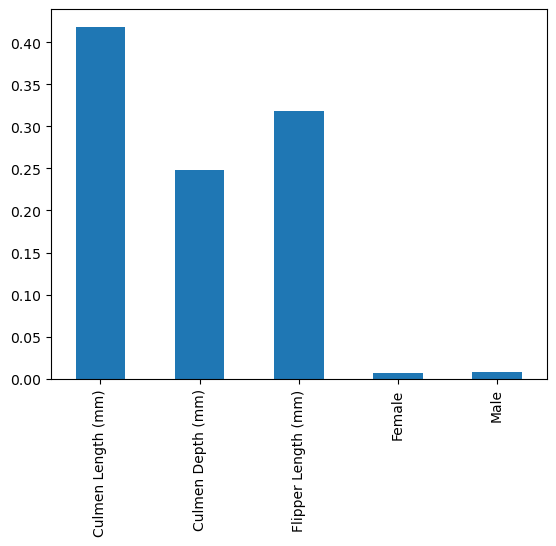

In [13]:
pd.Series(rf.named_steps["classifier"].feature_importances_, index=num_features+['Female', 'Male']).plot.bar()
plt.show()

The tree-based feature importance shows the importances as the "random forest sees them", which means we get the `Sex` feature split into male and female from the OneHotEncoding. This also means that this categorical features is correlated strongly.

We can clearly see that the `Culmen length` is the most important feature in determining which penguin we're facing. `Culmen depth` seems to be slightly less important than `Flipper length`. `Sex` seems to be entirely unimportant.

Now we can use the more sophisticated permutation importance. 

Luckily, scikit-learn implements this feature for us and we can just import it:

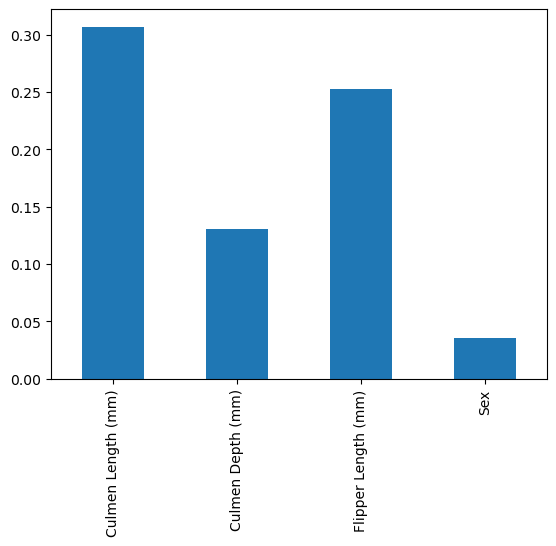

In [16]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42
)

pd.Series(result.importances_mean, index=features).plot.bar()
plt.show()

We can see that the permutation importance gives a lower weight to `Culmen Depth` in the Random Forest and a slightly higher importance to `Sex`.

Overall it's similar in that `Culmen Length` is still the most important and `Flipper length` is the second most important, while the relative importance changes somewhat. 

These differences can be much more pronounced in more complex models.

The really neat feature is however, that we can apply this to the SVM model, which does not have internal importances!

We can even add in uncertainties with the `n_repeats` keyword that runs the permutation importance repeatedly. 

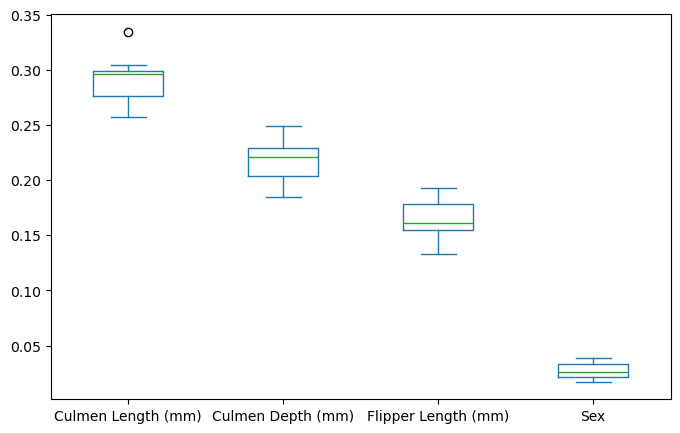

In [36]:
result = permutation_importance(
    model, X_train, y_train, n_repeats=10, random_state=42
)

pd.DataFrame(result.importances.T, columns=features).plot.box(figsize=(8, 5))
plt.show()

Here we can see that `Culmen length` is still the most important and `Sex` is mostly unimportant, but the relative importances of `Culmen depth` and `Flipper length` change.

Another valuable insight is evaluating a model's feature importance against the training and test set. A discrepancy in the scores would suggest potential overfitting to certain features. (If you're curious, add a feature with random data in this notebook and re-run the cells!) 

In the next figure, I will show you how to combine the uncertainties from the multiple runs of the premutation importance, two models, and the train-test-split into a single figure of grouped boxplots for machine learning explainability.

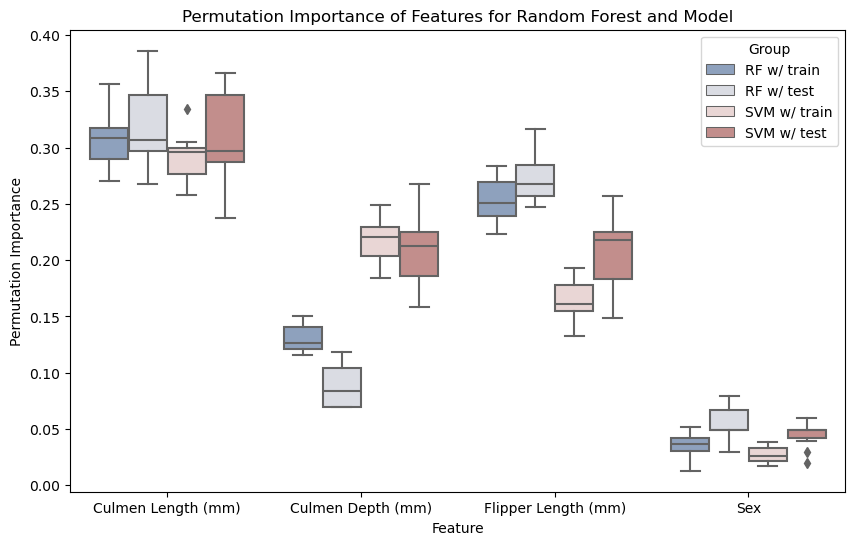

In [42]:
import seaborn as sns

# Step 2: Compute permutation importance for both models
rf_perm_importance_train = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=42)
rf_perm_importance_test = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

model_perm_importance_train = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
model_perm_importance_test = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Create DataFrames for permutation importance results
rf_train_df = pd.DataFrame(rf_perm_importance_train.importances.T, columns=X_train.columns)
rf_test_df = pd.DataFrame(rf_perm_importance_test.importances.T, columns=X_test.columns)
model_train_df = pd.DataFrame(model_perm_importance_train.importances.T, columns=X_train.columns)
model_test_df = pd.DataFrame(model_perm_importance_test.importances.T, columns=X_test.columns)

# Add 'Group' column to identify training and testing data
rf_train_df["Group"] = "RF w/ train"
rf_test_df["Group"] = "RF w/ test"
model_train_df["Group"] = "SVM w/ train"
model_test_df["Group"] = "SVM w/ test"

# Concatenate DataFrames
df = pd.concat([rf_train_df, rf_test_df, model_train_df, model_test_df])

# Melt the DataFrame
melted_df = pd.melt(df, id_vars=["Group"], var_name="Feature", value_name="Permutation Importance")

# Plot grouped box plots using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x="Feature", y="Permutation Importance", hue="Group", data=melted_df, palette="vlag")
plt.title("Permutation Importance of Features for Random Forest and Model")
plt.xlabel("Feature")
plt.ylabel("Permutation Importance")
plt.show()

We can see that the train and test data are mostly in agreement. This is a sign that the models aren't overfit on certain features, which we covered in [the Evaluation notebook](/notebooks/1-model-evaluation.html). The random forest shows some minor discrepancy in the `Culmen Depth`, which makes sense, as random forests are generally known to fit data very closely to the point of overfitting.

The SVM and random forest also show differences in importance in the `Culmen Depth` which shows that we can't run permutation importances on arbitrary cheaper models and evaluate the features to use for a more complex and expensive model.

And it looks like penguins do not show sexual dimorphism, which seems to be congruent with a shallow literature search! 🐧

## Shap Inspection

SHAP (SHapley Additive exPlanations) is a powerful tool for model inspection that provides intuitive insights into individual predictions and feature contributions.

We'll start with a small random forest and prepare the shapley values and initialise javascript for these fancy plots.

In [48]:
import shap

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train[num_features], y_train)

explainer = shap.Explainer(rf)
explainer

In [49]:
shap_values = explainer.shap_values(X_test[num_features])

In [50]:
shap.initjs()

One of the most compelling visualizations offered by SHAP is the force plot. This plot offers a comprehensive view of how each feature contributes to the model's prediction for a specific instance (local explainability). The force plot displays the magnitude and direction of each feature's impact on the prediction, allowing users to interpret how changes in feature values affect the model's output.

In [61]:
shap.force_plot(
    explainer.expected_value[0], shap_values[0][0], feature_names=num_features, out_names=y_test.iloc[0]
)

 By examining the force plot, we can identify which features have the greatest influence on individual predictions and understand the complex interactions between features. 
 
 Now we learn that `Culmen length` is important, and in this case it pushes the prediction against the `Culmen Depth` and `Flipper length` for the first sample in our test dataset.
 
 This level of transparency and interpretability is invaluable for building trust in machine learning models, as it enables users to diagnose model behavior, detect biases, and identify potential areas for improvement. Overall, SHAP force plots empower users to gain deeper insights into model predictions and make more informed decisions in various domains, including healthcare, finance, and beyond.

 But we can also create these force plots as an area chart over the entire test set. This plot orders the samples by similarity and presents them in an interactive chart.

In [63]:
shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=num_features, out_names=y_test.tolist())

We can make out three different sections of similar behaviour, which correspond to our three classes.

You can hover over the different values for more information.

## Model Inspection

There are several tools that work for figuring out that a model is doing what it's supposed to do. Scikit-learn classifiers mostly work out of the box, which is why we don't necessarily have to debug the models.

Sometimes we have to switch off regularization in scikit-learn to achieve the model state we expect.

In neural networks we are working with many moving parts. The first step is a practical step: Overfit a small batch of data on the network. This ensures that the model is capable of learning and all the connections are made as expected. This works as a first-order sense check that models are performing.

A more in-depth solution for Pytorch is [Pytorch Surgeon](https://github.com/archinetai/surgeon-pytorch), which can be used to extract submodels of the complete architecture for debugging purposes.

Some example code from the Pytorch Surgeon Docs (torch and surgeon are not installed to save space):


In [18]:
import torch
import torch.nn as nn
from surgeon_pytorch import Extract, get_nodes

class SomeModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(5, 3)
        self.layer2 = nn.Linear(3, 2)
        self.layer3 = nn.Linear(1, 1)

    def forward(self, x):
        x1 = torch.relu(self.layer1(x))
        x2 = torch.sigmoid(self.layer2(x1))
        y = self.layer3(x2).tanh()
        return y

model = SomeModel()
print(get_nodes(model)) # ['x', 'layer1', 'relu', 'layer2', 'sigmoid', 'layer3', 'tanh']

ModuleNotFoundError: No module named 'torch'

This enables us to extract the model at one of the nodes above:

In [19]:
model_ext = Extract(model, node_out='sigmoid')
x = torch.rand(1, 5)
sigmoid = model_ext(x)
print(sigmoid) # tensor([[0.5570, 0.3652]], grad_fn=<SigmoidBackward0>)

NameError: name 'Extract' is not defined